In [4]:
!pip install matplotlib-venn

In [2]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

4423680/4422102 [==============================] - 0s 0us/step


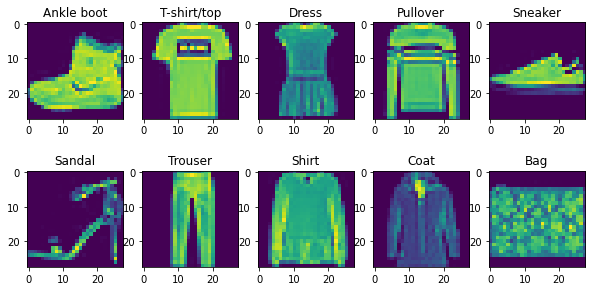

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5)) 

plottedClass =  [False for i in range(10)] 
count=0
for i in range(25):
    if  plottedClass[y_train[i]]==False:
      plt.subplot(2,5,count+1).set_title(labels[y_train[i]]) 
      plt.imshow(X_train[i])
      plottedClass[y_train[i]]=True
      count=count+1

plt.show()